IST - DBM2

# Data mining Project: : Titanic disaster Analysis

## Chad Long & Francesca Costa



The goal of this project is to analyse a dataset about the Titanic disaster with some methods studied in class.

Let's start  by presenting the data:

In [783]:
import pandas as pd
import csv
%matplotlib
from scipy.stats import chi2_contingency
import numpy as np
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
import warnings
warnings.filterwarnings('ignore')

Using matplotlib backend: MacOSX


In [778]:
data = pd.read_csv('/Users/Francesca/Desktop/titanic1/train.csv')
data.columns = ['PassengerID', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 
               'Ticket', 'Fare', 'Cabin', 'Embarked']

data.head(10)


,PassengerID,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


First of all, we want to check if there're some duplicated rows (and delete them in case).

In [644]:
dups = data.duplicated()
print('Number of duplicate rows = %d' % (dups.sum()))

Number of duplicate rows = 0


There are no duplicated rows, so we can procede.


We want to look in more details at the numbers of tuples and attributes; our attention is focused on the presence of missing values 

In [779]:
print('Number of instances = %d' % data.shape[0])
print('Number of attributes = %d' % data.shape[1])

print('Number of missing values:')
for col in data.columns:
    print('\t%s: %d' % (col, data[col].isna().sum()))

Number of instances = 891
Number of attributes = 12
Number of missing values:
	PassengerID: 0
	Survived: 0
	Pclass: 0
	Name: 0
	Sex: 0
	Age: 177
	SibSp: 0
	Parch: 0
	Ticket: 0
	Fare: 0
	Cabin: 687
	Embarked: 2


As we can see, in our dataset there are 891 istances and 12 attributes. However, not all columns are really needed for our analysis and we want to drop them.
In this first step we will delete:
- PassegnerID
- Name
- Ticket

In [800]:
dataShort = data.drop(['PassengerID','Name', 'Ticket'],axis=1)

dataShort.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,7.2500,NaN,S
1,1,1,female,38.0,1,0,71.2833,C85,C
2,1,3,female,26.0,0,0,7.9250,NaN,S
3,1,1,female,35.0,1,0,53.1000,C123,S
4,0,3,male,35.0,0,0,8.0500,NaN,S


We noticed that 3 columns present some missing values:
- Age
- Cabin
- Embarked

In [647]:
total = dataShort.isnull().sum().sort_values(ascending=False)
percent_1 = dataShort.isnull().sum()/dataShort.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data.head(3)

,Total,%
Cabin,687,77.1
Age,177,19.9
Embarked,2,0.2


The column 'Cabin' presents lots of missing values (77% of the total). We decided to drop it.

In [801]:
dataShort = dataShort.drop(['Cabin'],axis=1)

dataShort.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


Then, in order to fill 'Age' missing values, we decided to replace NaN with the female average age for female passengers and the male average age for male passengers (rounded).

In [802]:
women = dataShort[dataShort['Sex']=='female']
women_avgAge = round(women["Age"].mean())
print('Women average age = %d' % women_avgAge)

men = dataShort[dataShort['Sex']=='male']
men_avgAge = round(men["Age"].mean())
print('Men average age = %d' % men_avgAge)

Women average age = 28
Men average age = 31


In [803]:
dataShort.loc[(dataShort.Sex =='female') & (dataShort.Age.isnull()), 'Age'] = women_avgAge
dataShort.loc[(dataShort.Sex == 'male') & (dataShort.Age.isnull()), 'Age'] = men_avgAge

dataShort.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


Instead of using only the average age, it would have been interesting also considering the presence of children, parents, wife/husband in order to stimate the missing age value.
However, the dataset provides information about siblings-spose, parents-children combined together; this makes our idea unfeasible.

The column 'Embarked' has only 2 missing values. Counting the different values we obtain:

In [651]:
data['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

We decided to fill those missing two values with the most probable value S (Southampton).

In [804]:
dataShort.loc[dataShort.Embarked.isnull(), 'Embarked'] = 'S'

Let's check the number of missing values now:

In [654]:
print('Number of instances = %d' % dataShort.shape[0])
print('Number of attributes = %d' % dataShort.shape[1])

print('Number of missing values:')
for col in dataShort.columns:
    print('\t%s: %d' % (col, dataShort[col].isna().sum()))

Number of instances = 891
Number of attributes = 8
Number of missing values:
	Survived: 0
	Pclass: 0
	Sex: 0
	Age: 0
	SibSp: 0
	Parch: 0
	Fare: 0
	Embarked: 0


In [632]:
dataShort.to_csv('cleaned_data.csv', index = False)

Now that we've cleaned and tidied our dataset, let's procede in our analysis.

## Frequent pattern mining

Looking at the dataset, we came out with some assumptions about the relationship between the attributes. For example:
- the higher the class (lower number), the higher the prise
- people from the upper class could obtain a lifeboat more easily

We compute the correlation matrix to study the relationship between all the attributes.
In order to do that, we convert all attributes to numerical.

In [805]:
rep = {"male": 1, "female": 2}
dataShort.replace({'Sex' : rep}, inplace=True)

rep = {"S": 1, "C": 2, 'Q':3}
dataShort.replace({'Embarked' : rep}, inplace=True)

print("The correlation matrix is: \n")

corr = dataShort.corr(method='pearson')
corr.style.background_gradient(cmap='coolwarm')


The correlation matrix is: 



,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
Survived,1.000000,-0.338481,0.543351,-0.081736,-0.035322,0.081629,0.257307,0.106811
Pclass,-0.338481,1.000000,-0.131900,-0.329201,0.083081,0.018443,-0.549500,0.045702
Sex,0.543351,-0.131900,1.000000,-0.104850,0.114631,0.245489,0.182333,0.116569
Age,-0.081736,-0.329201,-0.104850,1.000000,-0.237059,-0.183536,0.088270,0.003538
SibSp,-0.035322,0.083081,0.114631,-0.237059,1.000000,0.414838,0.159651,-0.059961
Parch,0.081629,0.018443,0.245489,-0.183536,0.414838,1.000000,0.216225,-0.078665
Fare,0.257307,-0.549500,0.182333,0.088270,0.159651,0.216225,1.000000,0.062142
Embarked,0.106811,0.045702,0.116569,0.003538,-0.059961,-0.078665,0.062142,1.000000


From the correlation matrix we can notice that sex and survival are highly correlated.

In [809]:
rep = {1: "male", 2: "female"}
datac.replace({'Sex' : rep}, inplace=True)

sns.set(style="whitegrid")
ax = sns.countplot(y='Sex', hue="Survived", data=dataShort)
plt.ylabel('Sex')
plt.title('Survival Plot')
plt.show()

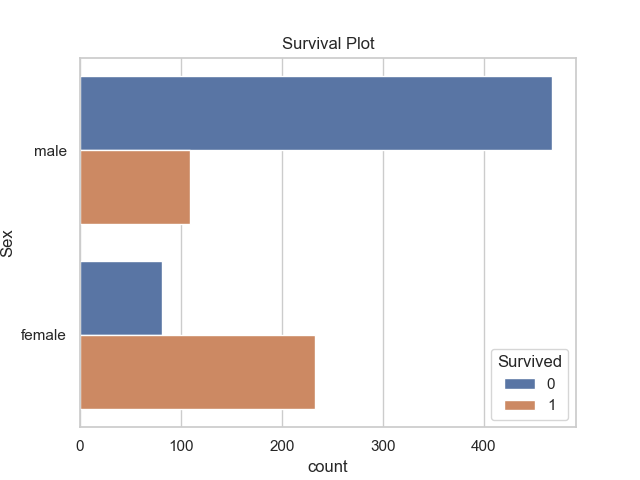

We can see that most of the survivals are women, even if the vast maggiority of passengers consists of men. The two attributes are positively correlated (they grow togheter); indeed, survival is identified with number 1 (death with 0), females with number 2 (males 1).

## Chiedere ad Andrea se questo ragionamento è giusto

We want also to show the correlation between the first class and the survival.

In [668]:
firstClass_survived = ((dataShort['Pclass'] == 1) & (dataShort['Survived']== 1)).sum()
firstClass_notSurvived = ((dataShort['Pclass'] == 1) & (dataShort['Survived']== 0)).sum()
otherClass_survived = ((dataShort['Pclass'] != 1) & (dataShort['Survived'] == 1)).sum()
otherClass_notSurvived = ((dataShort['Pclass'] != 1) & (dataShort['Survived'] == 0)).sum()

firstClass_total = (dataShort['Pclass'] == 1).sum()
otherClass_total = (dataShort['Pclass'] != 1).sum()
survived_total = (dataShort['Survived'] == 1).sum()
notSurvived_total = (dataShort['Survived'] == 0).sum()
total = survived_total + notSurvived_total

print('First class survived: ', firstClass_survived)
print('First class not survived: ', firstClass_notSurvived)
print('Other classes survived: ', otherClass_survived)
print('Other classes not survived: ', otherClass_notSurvived)
print('\nFirst class total: ', firstClass_total)
print('Other classes total: ', otherClass_total)
print('Survived total: ', survived_total)
print('Not survived total: ', notSurvived_total)
print('\nTotal sum: ', total)

First class survived:  136
First class not survived:  80
Other classes survived:  206
Other classes not survived:  469

First class total:  216
Other classes total:  675
Survived total:  342
Not survived total:  549

Total sum:  891


In [811]:
table = pd.DataFrame(
    [
        [136, 80, 216],
        [206, 469, 675],
        [342, 549, 891]
    ],
    index=["First class","Other classes", "Sum"],
    columns=["Survived","Not survived","Sum"])
table

,Survived,Not survived,Sum
First class,136,80,216
Other classes,206,469,675
Sum,342,549,891


We calculate the lift between first class and survivals.

In [813]:
firstClass_survived_probability = firstClass_survived / total
firstClass_probability = firstClass_total / total
survived_probability = survived_total / total

lift_firstSurvived = firstClass_survived_probability / (firstClass_probability*survived_probability)
print("The lift is: ", round(lift_firstSurvived, 2))

The lift is:  1.64


The lift value is > 1: it means that being in the first class and the survival are positive correlated

Trovare la classe in base a sesso, età e famiglia.
Trovare la correlazione tra prezzo del biglietto e classe e porto


Albero decisionale: fai diverse prove con diversi alberi decisionali con diverse feature in input per evitare l'overfitting
Non testare l'argoritmo solo su un dataset completo, ma provare varie features per verificare l'overfitting
Valutare la bontà dell'algoritmo con tutti i parametri della classificazione.
Valutare le metriche sempre sul test set
overfitting = all'algoritmo passi troppi parametri e l'argoritmo impara a memoria.
Non identifica l'andamento generico dei dati. Non è rappresentativo della varietà dei dati, ma solo dei dati già osservati
Accuratezza non è fiducia
- vuoi evitare falsi negative
- sbilanciato
Considerare anche recall e la precision
Modello stupido che considera solo la possibilità più alta.

Random forest
Grafico rispetto alla profondità del grafico e valutare l'overfitting

We want to perform the Apriori algorithm in order to find frequent itemsets.
To make things simpler and easier to understand, we decided to divided the 'Age' attribute in categories and to consider only 'Survived', 'Pclass', 'Sex', 'Age', 'Embarked' as attributes in this step.

In [703]:
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

In [ ]:
def binning(col, cut_points, labels=None):
  minval = col.min()
  maxval = col.max()
  break_points = [minval] + cut_points + [maxval]
  if not labels:
    labels = range(len(cut_points)+1)
  colBin = pd.cut(col,bins=break_points,labels=labels,include_lowest=True)
  return colBin

cut_points = [12, 20, 60 ]
labels = ["Child", "Teen", "Adult", "Old"]
dataShort['Age'] = binning(dataShort['Age'], cut_points, labels)

In [712]:
dataShort.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,Adult,1,0,7.2500,1
1,1,1,2,Adult,1,0,71.2833,2
2,1,3,2,Adult,0,0,7.9250,1
3,1,1,2,Adult,1,0,53.1000,1
4,0,3,1,Adult,0,0,8.0500,1
5,0,3,1,Adult,0,0,8.4583,3
6,0,1,1,Old,0,0,51.8625,1
7,0,3,1,Child,3,1,21.0750,1
8,1,3,2,Adult,0,2,11.1333,1
9,1,2,2,Teen,1,0,30.0708,2


In [727]:
data_ap = dataShort.drop(['SibSp', 'Parch', 'Fare'], axis = 1)

data_ap.head()

,Survived,Pclass,Sex,Age,Embarked
0,0,3,1,Adult,1
1,1,1,2,Adult,2
2,1,3,2,Adult,1
3,1,1,2,Adult,1
4,0,3,1,Adult,1


In [749]:
rep = {0: "Survived", 1: "Not survived"}
data_ap.replace({'Survived' : rep}, inplace=True)

rep = {1: "Southampton", 2: "Cherbourg", 3:"Queenstown"}
data_ap.replace({'Embarked' : rep}, inplace=True)

rep = {1: "First class", 2: "Second class", 3:"Third class"}
data_ap.replace({'Pclass' : rep}, inplace=True)

rep = {1: "male", 2: "female"}
data_ap.replace({'Sex' : rep}, inplace=True)

data_ap.head()

,Survived,Pclass,Sex,Age,Embarked
0,Survived,Third class,male,Adult,Southampton
1,Not survived,First class,female,Adult,Cherbourg
2,Not survived,Third class,female,Adult,Southampton
3,Not survived,First class,female,Adult,Southampton
4,Survived,Third class,male,Adult,Southampton


In [775]:
dataset = []


for i in range(0, data_ap.shape[0]):
    dataset.append([str(data_ap.values[i,j]) for j in range(0, data_ap.shape[1])])

oht = TransactionEncoder()
oht_ary = oht.fit(dataset).transform(dataset)
df = pd.DataFrame(oht_ary, columns=oht.columns_)
df

,Adult,Cherbourg,Child,First class,Not survived,Old,Queenstown,Second class,Southampton,Survived,Teen,Third class,female,male
0,True,False,False,False,False,False,False,False,True,True,False,True,False,True
1,True,True,False,True,True,False,False,False,False,False,False,False,True,False
2,True,False,False,False,True,False,False,False,True,False,False,True,True,False
3,True,False,False,True,True,False,False,False,True,False,False,False,True,False
4,True,False,False,False,False,False,False,False,True,True,False,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,True,False,False,False,False,False,False,True,True,True,False,False,False,True
887,False,False,False,True,True,False,False,False,True,False,True,False,True,False
888,True,False,False,False,False,False,False,False,True,True,False,True,True,False
889,True,True,False,True,True,False,False,False,False,False,False,False,False,True


In [776]:
frq_items = apriori(df, min_support = 0.2, use_colnames = True)

rules = association_rules(frq_items, metric = "lift", min_threshold = 1)
rules = rules.sort_values(['confidence', 'lift'], ascending = [False, False])

rules


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
113,"(Third class, Adult, male)",(Survived),0.294052,0.616162,0.258137,0.877863,1.424728,0.076954,3.142677
127,"(Third class, Southampton, male)",(Survived),0.297419,0.616162,0.259259,0.871698,1.414723,0.076001,2.991682
65,"(Third class, male)",(Survived),0.389450,0.616162,0.336700,0.864553,1.403128,0.096736,2.833871
34,"(Adult, Survived)",(male),0.460157,0.647587,0.397306,0.863415,1.333280,0.099315,2.580167
84,"(Southampton, Adult, Survived)",(male),0.351291,0.647587,0.303030,0.862620,1.332052,0.075539,2.565239
...,...,...,...,...,...,...,...,...,...
111,(male),"(Third class, Southampton, Adult)",0.647587,0.283951,0.218855,0.337955,1.190189,0.034972,1.081572
80,(Southampton),"(Third class, Adult, Survived)",0.725028,0.313131,0.234568,0.323529,1.033207,0.007539,1.015371
81,(Adult),"(Third class, Southampton, Survived)",0.727273,0.320988,0.234568,0.322531,1.004808,0.001122,1.002278
108,(Southampton),"(Third class, Adult, male)",0.725028,0.294052,0.218855,0.301858,1.026546,0.005660,1.011181


## Chiedere ad Andrea cosa significano tutte quelle colonne che non sono support, lift and confindence

## Classification